Basic analyses of behavior in the FHT task. 

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
import math

# 1. Load and prep behavioral data

In [2]:
behav_path = os.getcwd() + '/ProcessedData/AllData.csv' # this expects ProcessedData to be in the analysis repo
behav_data = pd.read_csv(behav_path)
subjects = behav_data['Subj'].unique()

## Get metadata.
n_trials = max(behav_data['Trial'])
n_games = max(behav_data['Game'])
game_length = len(behav_data.loc[(behav_data['Subj'] == 23) & (behav_data['Game'] == 1)])

# change subj to int
behav_data['Subj'] = behav_data['Subj'].astype(int)

## Add trial-within-game variable.
behav_data['WithinGameTrial'] = behav_data['Trial'] - (behav_data['Game']-1)*game_length
behav_data = behav_data.fillna(0)

In [3]:
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Outcome,Dim,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,PoL,RT,WithinGameTrial
0,23,1,1,1,6,8,2,5,7,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,1.12700,1
1,23,2,1,2,5,7,1,4,8,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,1.08580,2
2,23,3,1,3,4,7,2,5,9,1,...,0.0,1,2,0.0,0.0,0.0,0.0,0.0,1.24420,3
3,23,4,1,1,4,7,2,5,8,3,...,0.0,1,2,0.0,0.0,1.0,0.0,0.0,0.47509,4
4,23,5,1,1,6,8,2,4,7,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.88090,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.61252,16
15196,71,397,20,1,5,8,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.89898,17
15197,71,398,20,1,6,7,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.59331,18
15198,71,399,20,1,6,7,3,5,8,2,...,1.0,1,2,0.0,0.0,1.0,0.0,0.0,0.52019,19


# 2. Subset data to learning phase
We'll calculate the point of learning for each game, which is the first correct choice in a streak of correct choices (80% correct selections on subsequent trials.)

In [4]:
subj_trial = behav_data[['Subj', 'Trial', 'Game', 'WithinGameTrial', 'Correct']]
subj_trial

,Subj,Trial,Game,WithinGameTrial,Correct
0,23,1,1,1,1.0
1,23,2,1,2,1.0
2,23,3,1,3,0.0
3,23,4,1,4,1.0
4,23,5,1,5,1.0
...,...,...,...,...,...
15195,71,396,20,16,1.0
15196,71,397,20,17,1.0
15197,71,398,20,18,1.0
15198,71,399,20,19,1.0


In [5]:
numCorrectOnSubsequentTrials = {'Subj': [], 'Game' : [],'WithinGameTrial': [], 'SubsequentCorrect': [], 'AllCorrect': []}
pol_df = {'SubjGame': [], 'Subj': [], 'Game': [], 'PoL': [], 'SubsequentCorrect':[]}
sub_group = subj_trial
for trial_num in range(0,20):
    sub_group = sub_group.loc[sub_group['WithinGameTrial'] != trial_num]
    sub_grouped = sub_group.groupby(['Subj', 'Game']).Correct
    sub_grouped = sub_grouped.sum().reset_index()
    for index, items in sub_grouped.iterrows():
        numCorrectOnSubsequentTrials['Subj'].append(items.Subj)
        numCorrectOnSubsequentTrials['Game'].append(items.Game)
        numCorrectOnSubsequentTrials['WithinGameTrial'].append(trial_num+1) 
        numCorrectOnSubsequentTrials['SubsequentCorrect'].append(items.Correct)
        allCorrect = (20-trial_num)
        if items.Correct >= allCorrect:
            numCorrectOnSubsequentTrials['AllCorrect'].append(True)
            if (items.Subj, items.Game) not in pol_df['SubjGame']:
                pol_df['SubjGame'].append((items.Subj, items.Game))
                pol_df['Subj'].append(items.Subj)
                pol_df['Game'].append(items.Game)
                pol_df['SubsequentCorrect'].append(items.Correct)
                pol_df['PoL'].append(trial_num+1)
        else:
            numCorrectOnSubsequentTrials['AllCorrect'].append(False)       

In [6]:
pol_df = pd.DataFrame.from_dict(pol_df)
pol_graph_data = pol_df.groupby(['PoL'])['SubjGame'].count().reset_index()

In [7]:
pol_graph_data

,PoL,SubjGame
0,1,24
1,2,18
2,3,27
3,4,37
4,5,34
5,6,36
6,7,28
7,8,29
8,9,23
9,10,27


Text(0.5, 1.0, 'Point of 100% Accuracy')

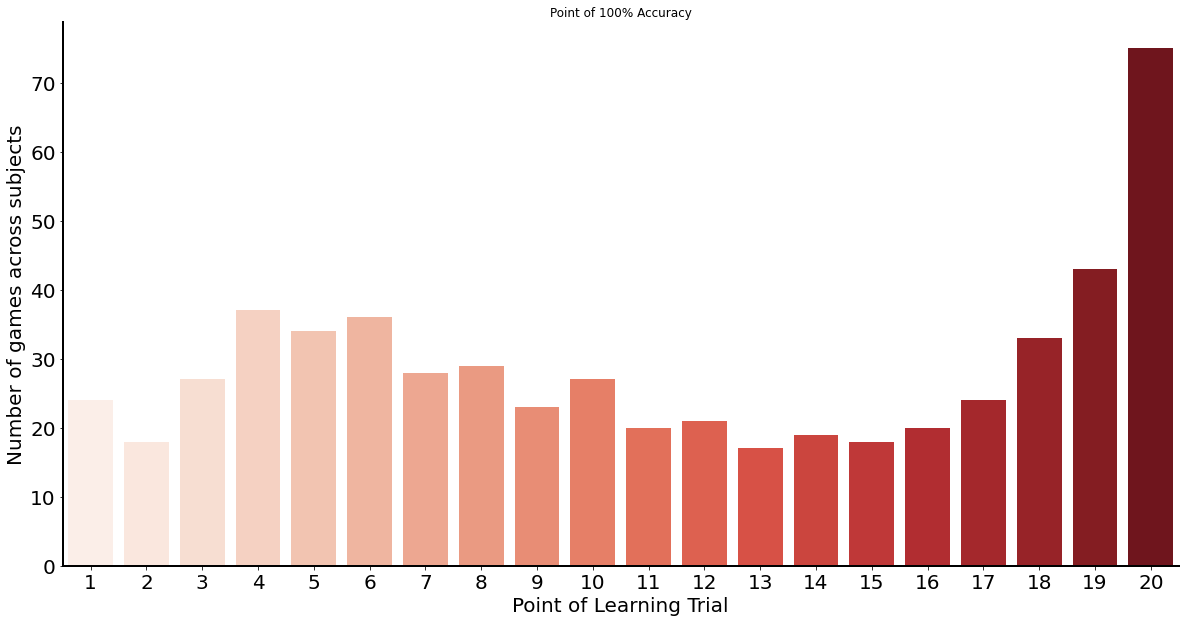

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="PoL", y="SubjGame", data=pol_graph_data, palette="Reds");
sns.despine()
# ax.set_ylim([0,1.01])
yl = ax.set_ylabel('Number of games across subjects',fontsize = 20);
xl = ax.set_xlabel('Point of Learning Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=20)
ax.set_title('Point of 100% Accuracy')

In [9]:
pol_df = pol_df.drop(columns=['SubjGame', 'SubsequentCorrect'])
behav_data = behav_data.merge(pol_df, on=['Subj', 'Game'], how='left')
behav_data['PoL'] = behav_data['PoL_y']
behav_data = behav_data.drop(columns=['PoL_x', 'PoL_y'])

In [10]:
behav_data['LearnedFeat'] = behav_data['PoL'] < 16
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Outcome,Dim,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,RT,WithinGameTrial,PoL
0,23,1,1,1,6,8,2,5,7,3,...,1.0,1,2,0.0,0.0,1.0,False,1.12700,1,18.0
1,23,2,1,2,5,7,1,4,8,3,...,1.0,1,2,0.0,0.0,1.0,False,1.08580,2,18.0
2,23,3,1,3,4,7,2,5,9,1,...,0.0,1,2,0.0,0.0,0.0,False,1.24420,3,18.0
3,23,4,1,1,4,7,2,5,8,3,...,0.0,1,2,0.0,0.0,1.0,False,0.47509,4,18.0
4,23,5,1,1,6,8,2,4,7,3,...,1.0,1,2,0.0,0.0,1.0,False,0.88090,5,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,1.0,1,2,0.0,0.0,1.0,True,0.61252,16,6.0
15196,71,397,20,1,5,8,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,True,0.89898,17,6.0
15197,71,398,20,1,6,7,2,4,9,3,...,1.0,1,2,0.0,0.0,1.0,True,0.59331,18,6.0
15198,71,399,20,1,6,7,3,5,8,2,...,1.0,1,2,0.0,0.0,1.0,True,0.52019,19,6.0


In [11]:
# import agemap
ageMap = pd.read_csv(os.getcwd() + '/ProcessedData/ageMap.csv')
ageMap

,Age,Subject_ID
0,15.105033,23
1,15.378824,24
2,19.775902,25
3,23.299589,26
4,14.568403,27
5,13.987967,28
6,16.723136,29
7,17.393923,30
8,17.632121,31
9,30.344223,32


Text(0.5, 1.0, 'Point of 100% Accuracy')

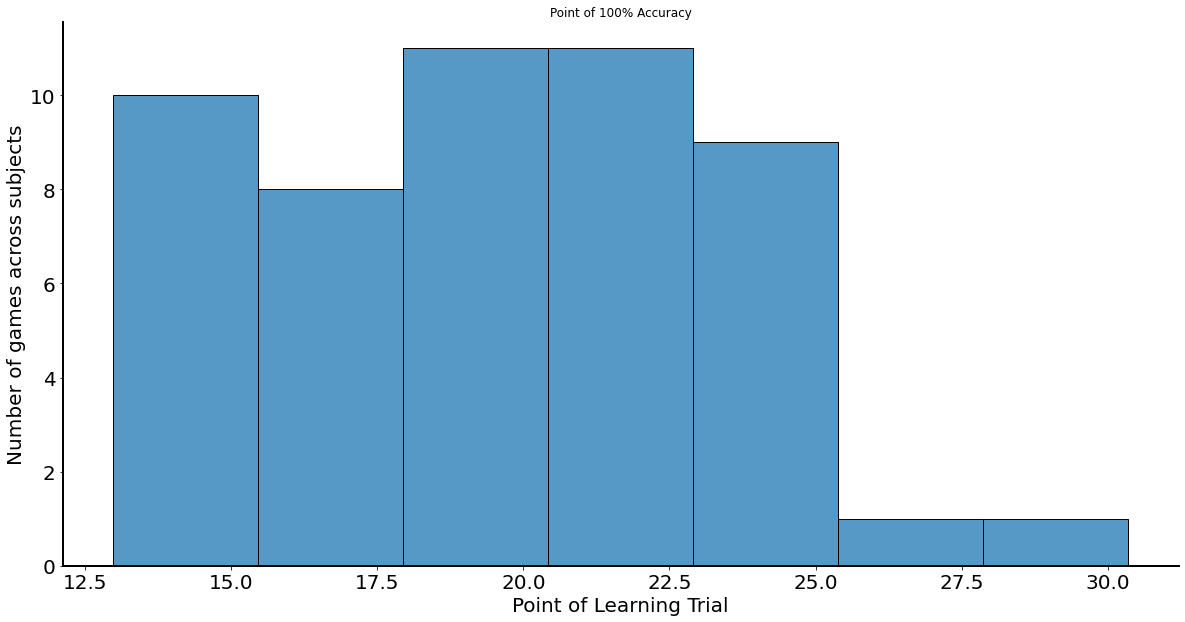

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
sns.histplot(data=ageMap, x="Age", palette="Reds");
sns.despine()
# ax.set_ylim([0,1.01])
yl = ax.set_ylabel('Number of games across subjects',fontsize = 20);
xl = ax.set_xlabel('Point of Learning Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=20)
ax.set_title('Point of 100% Accuracy')

In [14]:
# add age related columns in behavioral dataframe
behav_data["Adult"] = False
behav_data['Age'] = np.nan
for index, row in behav_data.iterrows():
    subj_id = int(row.Subj)
    age = ageMap.loc[ageMap['Subject_ID'] == subj_id].Age.item()
    if age < 10:
        behav_data.drop([index]) # remove 67 and 56 because no age info
    else:
        behav_data.loc[index, "Age"] = age
        if age >= 18:
            behav_data.loc[index, "Adult"] = True
behav_data = behav_data[behav_data['Age'].notna()]


In [15]:
age_group = []
for item, row in behav_data.iterrows():
    if row.Adult:
        age_group.append('Adult')
    else:
        age_group.append('Adolescent')
behav_data['AgeGroup'] = age_group

In [16]:
good_behav_data = behav_data[behav_data['Subj'] != 33]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 66]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 58]
good_behav_data = good_behav_data.reset_index(drop=True)
good_behav_data.to_csv(os.getcwd() + '/ProcessedData/CleanedProcessedBehavioralData.csv', index=False)

## Grab Learning Trials Only

In [50]:
learning_trials = behav_data.loc[behav_data['LearnedGame']]

In [51]:
learning_trials['AlignedTrial'] = learning_trials['WithinGameTrial'] - learning_trials['PoL']
learning_trials

/var/folders/wg/m30l6kjs09l1pxs4fshqx1xxjyhc2c/T/ipykernel_4862/1915120393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  learning_trials['AlignedTrial'] = learning_trials['WithinGameTrial'] - learning_trials['PoL']


,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,CenterFeat,Correct,LearnedGame,RT,WithinGameTrial,PoL,Adult,Age,AgeGroup,AlignedTrial
20,23,21,2,2,4,8,3,6,9,1,...,0.0,0.0,True,1.34940,1,7.0,False,15.105033,Adolescent,-6.0
21,23,22,2,2,6,9,1,4,8,3,...,0.0,1.0,True,0.55658,2,7.0,False,15.105033,Adolescent,-5.0
22,23,23,2,1,6,9,2,5,7,3,...,0.0,1.0,True,1.29170,3,7.0,False,15.105033,Adolescent,-4.0
23,23,24,2,2,5,8,1,6,9,3,...,0.0,1.0,True,1.21820,4,7.0,False,15.105033,Adolescent,-3.0
24,23,25,2,3,5,9,1,6,7,2,...,0.0,1.0,True,1.75240,5,7.0,False,15.105033,Adolescent,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,0.0,1.0,True,0.61252,16,6.0,True,22.508334,Adult,10.0
15196,71,397,20,1,5,8,2,4,9,3,...,0.0,1.0,True,0.89898,17,6.0,True,22.508334,Adult,11.0
15197,71,398,20,1,6,7,2,4,9,3,...,0.0,1.0,True,0.59331,18,6.0,True,22.508334,Adult,12.0
15198,71,399,20,1,6,7,3,5,8,2,...,0.0,1.0,True,0.52019,19,6.0,True,22.508334,Adult,13.0


In [52]:
learning_trials.to_csv(os.getcwd() + '/ProcessedData/Learned_LearningTrials.csv', index=False)

Text(0.5, 1.0, 'Learning Curves over Learning Trials for Learned Subjects')

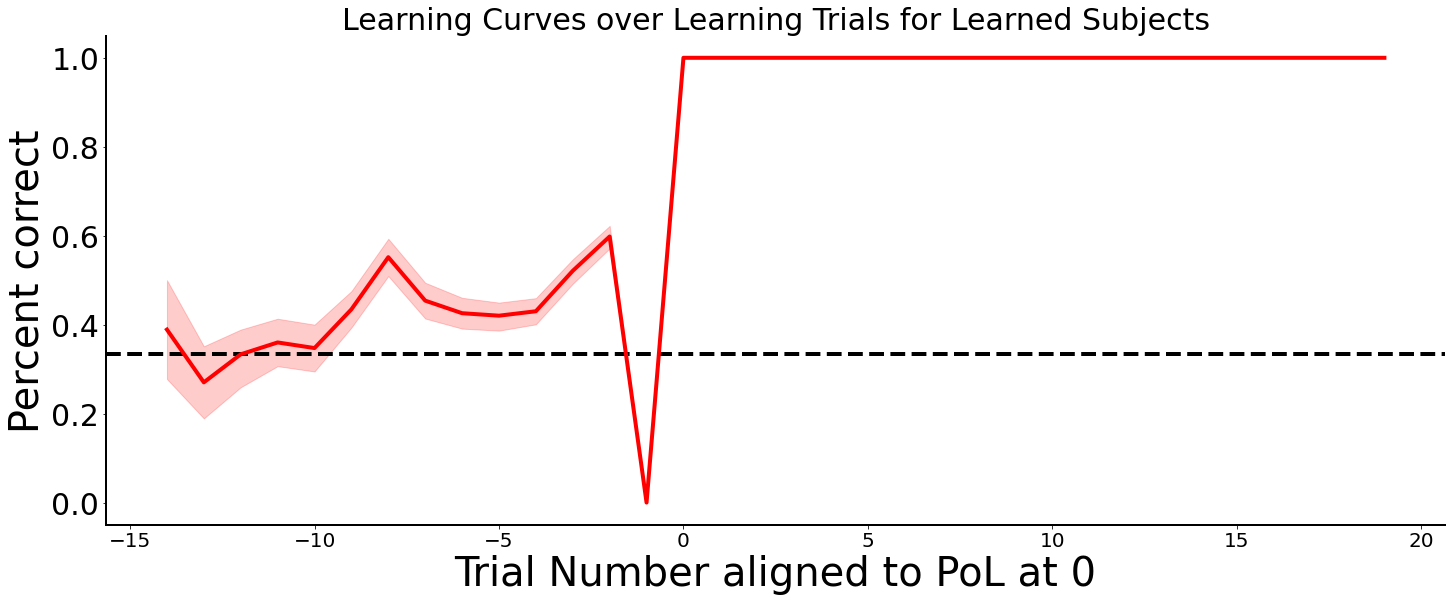

In [53]:
# pre point of learning trials
df = pd.melt(learning_trials, col_level=0, id_vars='AlignedTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(24,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'AlignedTrial', y="value", err_style="band", ci=68, data=df, lw=4, legend=False, color='red')
sns.despine()
# ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0.3,0.8])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial Number aligned to PoL at 0',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);
ax.set_title('Learning Curves over Learning Trials for Learned Subjects', fontsize=30)

In [54]:
# split by age
# split the dataframe into adult and adolescent dataframes
adult_learning = learning_trials.loc[behav_data['Adult']]
adole_learning = learning_trials.loc[behav_data['Adult'] == False]

In [22]:
adult_learning.loc[adult_learning['LearnedFeat']]
adole_learning.loc[adole_learning['LearnedFeat']]

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,CenterFeat,Correct,LearnedFeat,RT,WithinGameTrial,PoL,Adult,Age,AgeGroup,AlignedTrial
20,23,21,2,2,4,8,3,6,9,1,...,0.0,0.0,True,1.34940,1,7.0,False,15.105033,Adolescent,-6.0
21,23,22,2,2,6,9,1,4,8,3,...,0.0,1.0,True,0.55658,2,7.0,False,15.105033,Adolescent,-5.0
22,23,23,2,1,6,9,2,5,7,3,...,0.0,1.0,True,1.29170,3,7.0,False,15.105033,Adolescent,-4.0
23,23,24,2,2,5,8,1,6,9,3,...,0.0,1.0,True,1.21820,4,7.0,False,15.105033,Adolescent,-3.0
24,23,25,2,3,5,9,1,6,7,2,...,0.0,1.0,True,1.75240,5,7.0,False,15.105033,Adolescent,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12735,63,336,17,1,4,8,2,5,9,3,...,0.0,1.0,True,0.71881,16,6.0,False,16.884673,Adolescent,10.0
12736,63,337,17,1,4,9,3,6,8,2,...,0.0,1.0,True,0.71764,17,6.0,False,16.884673,Adolescent,11.0
12737,63,338,17,1,5,9,2,4,8,3,...,0.0,1.0,True,0.65219,18,6.0,False,16.884673,Adolescent,12.0
12738,63,339,17,1,5,9,2,4,8,3,...,0.0,1.0,True,0.49882,19,6.0,False,16.884673,Adolescent,13.0


Text(0.5, 1.0, 'Learning Curves over Learning Trials for Learned Subjects')

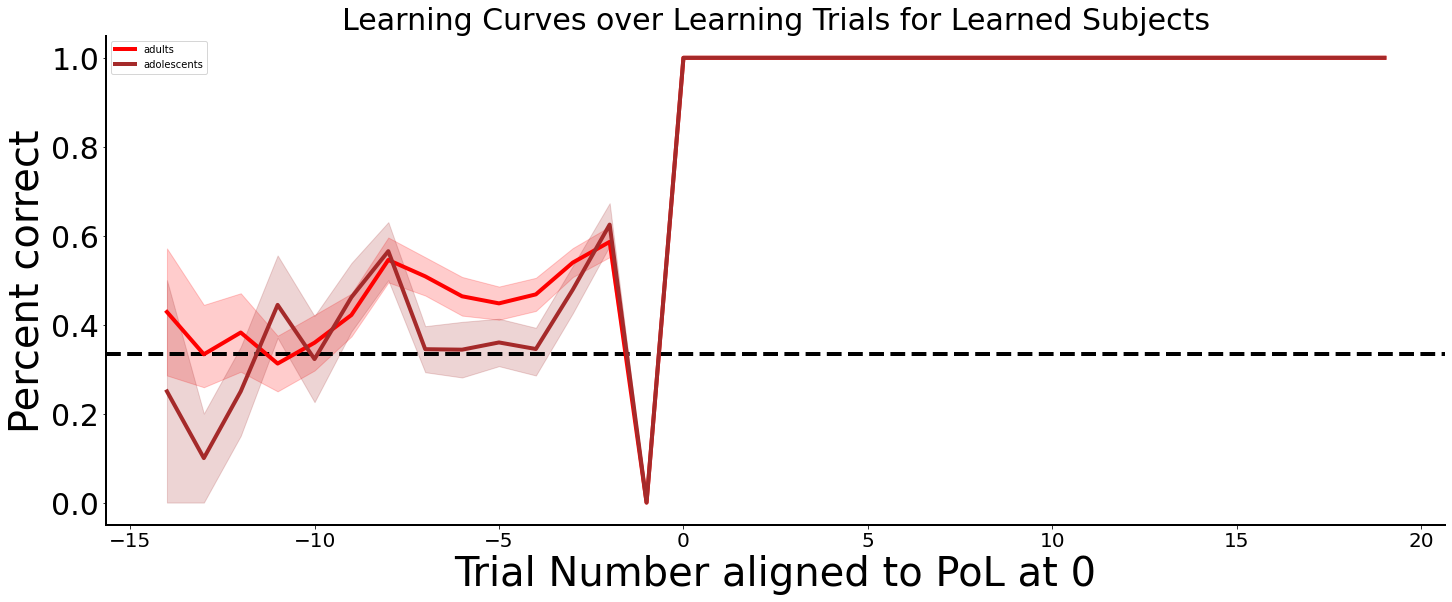

In [55]:
dfu = pd.melt(adult_learning, col_level=0, id_vars='AlignedTrial', value_vars=['Correct'])
dfo = pd.melt(adole_learning, col_level=0, id_vars='AlignedTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(24,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'AlignedTrial', y="value", err_style="band", ci=68, data=dfu, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'AlignedTrial', y="value", err_style="band", ci=68, data=dfo, lw=4, legend='brief', label='adolescents', color='brown')
sns.despine()
# ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0.3,0.8])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial Number aligned to PoL at 0',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);
ax.set_title('Learning Curves over Learning Trials for Learned Subjects', fontsize=30)

In [56]:
relative_looking_time_df = pd.read_csv('ProcessedData/PreChoice_RelativeLookingTimes.csv')
relative_looking_time_df

,Trial,Block,Subj,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,TotalLookingTime,FeatureEntropy,Animals,Landscapes,Objects,DimensionEntropy
0,1,1,23,0.160000,0.177143,0.00000,0.000000,0.145714,0.000000,0.488571,0.020000,0.000000,0.008571,1.400,0.595598,0.337143,0.145714,0.508571,0.902129
1,1,1,26,0.000000,0.000000,0.00000,0.000000,0.091873,0.000000,0.789753,0.000000,0.114841,0.003534,2.264,0.297776,0.000000,0.091873,0.904594,0.282207
2,1,1,27,0.000000,0.000000,0.13986,0.000000,0.000000,0.000000,0.000000,0.000000,0.800699,0.059441,1.144,0.206211,0.139860,0.000000,0.800699,0.412422
3,1,1,28,0.341598,0.000000,0.00000,0.000000,0.022039,0.000000,0.000000,0.181818,0.303030,0.151515,1.452,0.510982,0.341598,0.022039,0.484848,0.729998
4,1,1,29,0.000000,0.000000,0.00000,0.005141,0.002571,0.149100,0.681234,0.000000,0.161954,0.000000,1.556,0.401645,0.000000,0.156812,0.843188,0.395359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,400,10,67,0.000000,0.000000,0.00000,0.960366,0.000000,0.018293,0.000000,0.000000,0.000000,0.021341,1.312,0.050988,0.000000,0.978659,0.000000,0.019217
13996,400,10,68,0.000000,0.000000,0.00000,0.000000,0.000000,0.726640,0.000000,0.258449,0.000000,0.014911,1.006,0.264757,0.000000,0.726640,0.258449,0.529513
13997,400,10,69,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.268,-0.000000,0.000000,0.000000,1.000000,-0.000000
13998,400,10,70,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.624,-0.000000,0.000000,1.000000,0.000000,-0.000000


In [57]:
good_behav_data = behav_data[behav_data['Subj'] != 33]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 66]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 58]
good_behav_data = good_behav_data.reset_index(drop=True)
new_df = pd.merge(good_behav_data, relative_looking_time_df,  how='left', on=['Subj','Trial'])
new_df.to_csv(os.getcwd() + '/ProcessedData/PreChoice_Processed_CombinedBehavioralEyetrackingData.csv', index=False)

In [58]:
unlearned_trials = new_df[new_df['LearnedGame'] == False]
adole_unlearned_trials = unlearned_trials[unlearned_trials['Adult'] == False]
adult_unlearned_trials = unlearned_trials[unlearned_trials['Adult']]

In [59]:
learned_df = learning_trials.merge(relative_looking_time_df, on=['Subj', 'Trial'], how='left')
adole_combined_df = learned_df[learned_df['Adult'] == False]
adult_combined_df = learned_df[learned_df['Adult']]

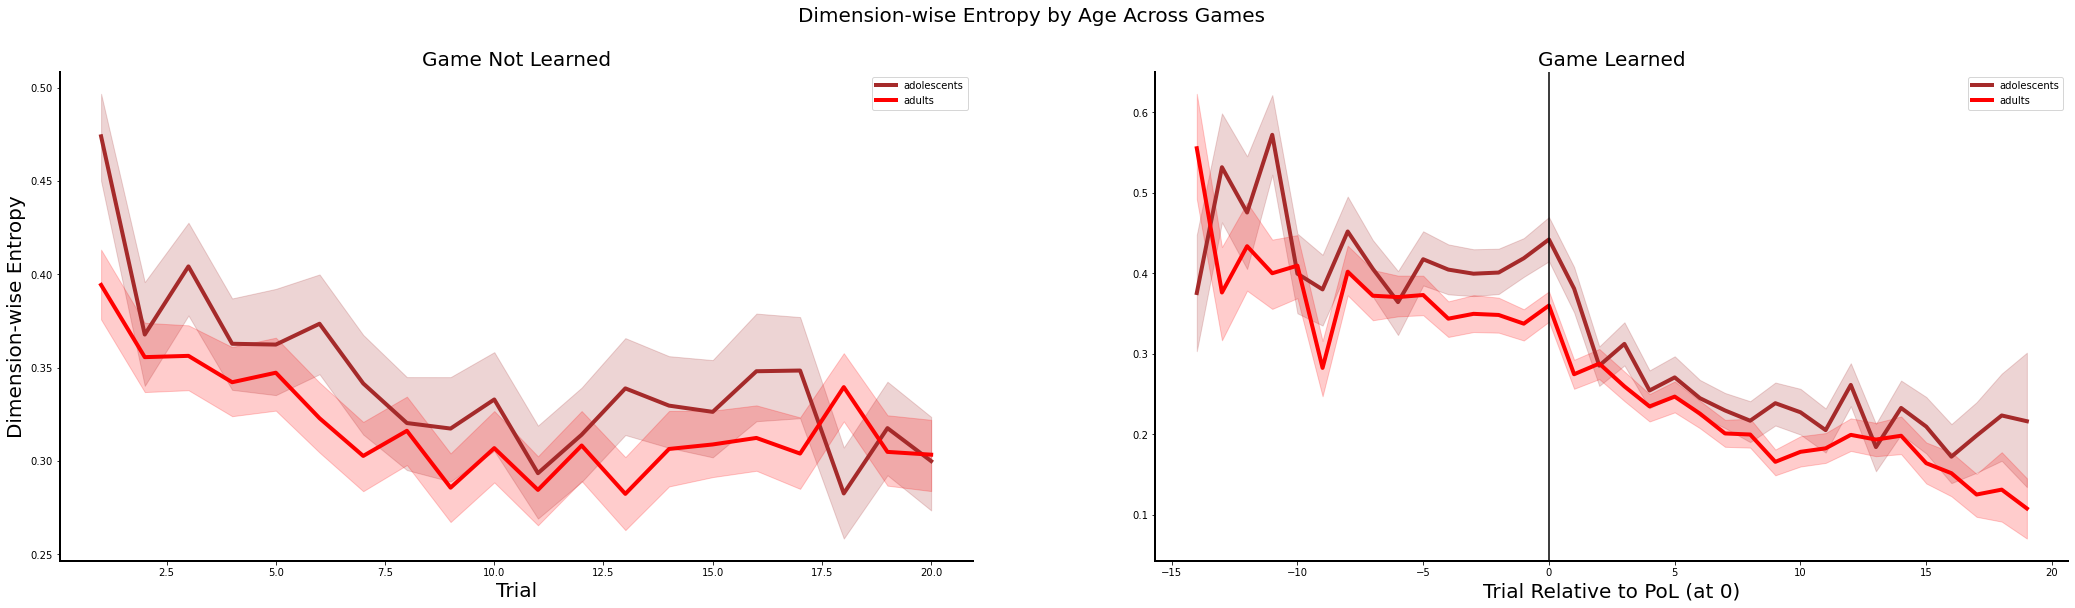

In [60]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['DimensionEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['DimensionEntropy'])

uncombined_df_adult = pd.melt(adult_unlearned_trials, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
uncombined_df_adole = pd.melt(adole_unlearned_trials, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(36,9))
fig.suptitle('Dimension-wise Entropy by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=68, data=uncombined_df_adole, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'AlignedTrial', y="value", err_style="band", ci=68, data=combined_df_adole, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=68, data=uncombined_df_adult, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'AlignedTrial', y="value", err_style="band", ci=68, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([0,1])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax2.set_ylim([0,1])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Dimension-wise Entropy',fontsize = 20);
x2 = ax2.set_xlabel('Trial Relative to PoL (at 0)',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')
ax2.axvline(x = 0, color = 'k', label = 'Point of Learning')

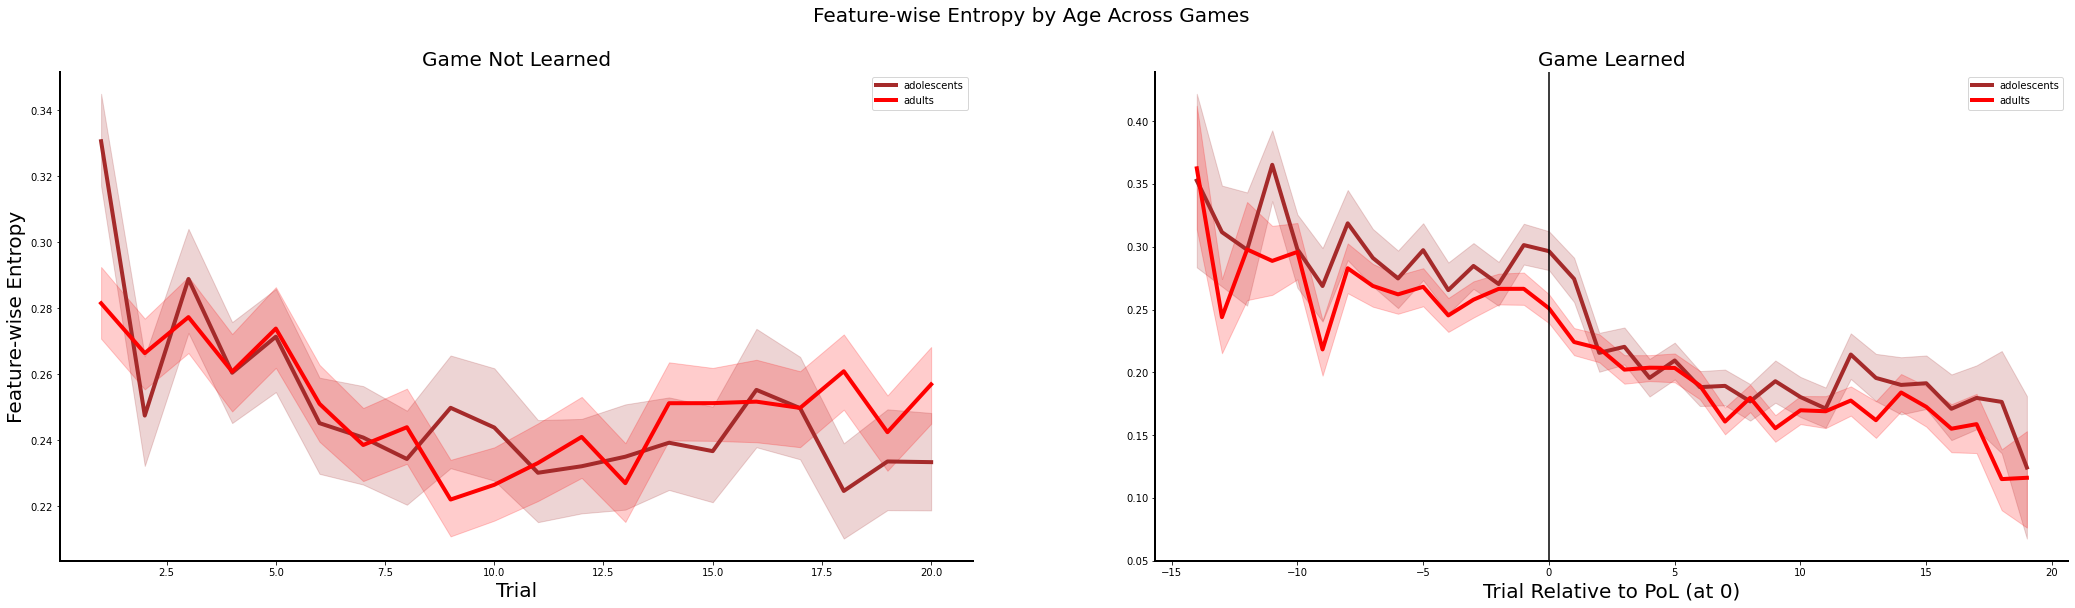

In [61]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['FeatureEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['FeatureEntropy'])

uncombined_df_adult = pd.melt(adult_unlearned_trials, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
uncombined_df_adole = pd.melt(adole_unlearned_trials, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(36,9))
fig.suptitle('Feature-wise Entropy by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=68, data=uncombined_df_adole, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'AlignedTrial', y="value", err_style="band", ci=68, data=combined_df_adole, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=68, data=uncombined_df_adult, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'AlignedTrial', y="value", err_style="band", ci=68, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([0,1])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax2.set_ylim([0,1])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Feature-wise Entropy',fontsize = 20);
x2 = ax2.set_xlabel('Trial Relative to PoL (at 0)',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')
ax2.axvline(x = 0, color = 'k', label = 'Point of Learning')

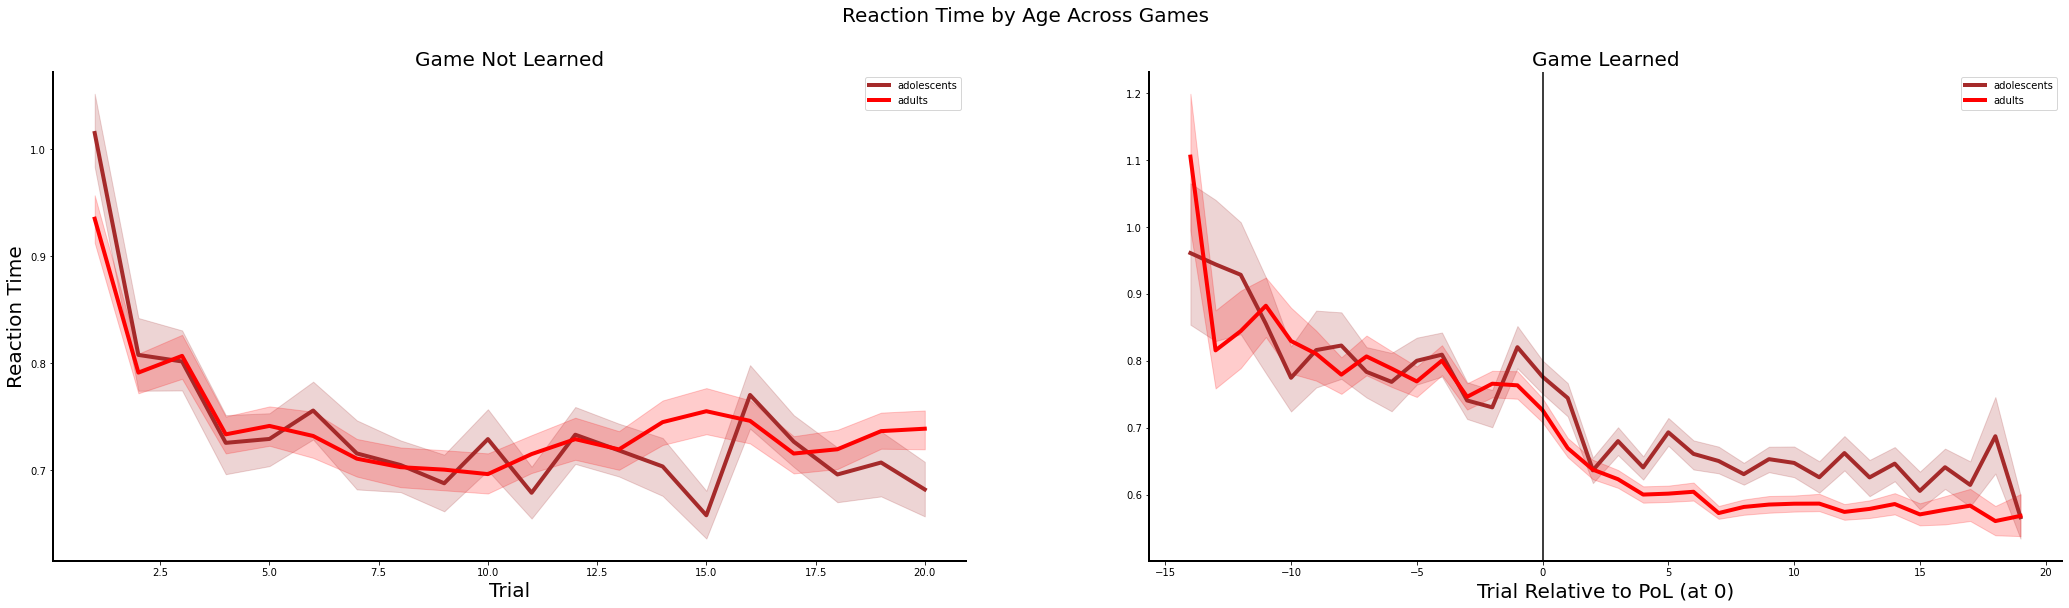

In [62]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['RT'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['RT'])

uncombined_df_adult = pd.melt(adult_unlearned_trials, col_level=0, id_vars='WithinGameTrial', value_vars=['RT'])
uncombined_df_adole = pd.melt(adole_unlearned_trials, col_level=0, id_vars='WithinGameTrial', value_vars=['RT'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(36,9))
fig.suptitle('Reaction Time by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=68, data=uncombined_df_adole, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'AlignedTrial', y="value", err_style="band", ci=68, data=combined_df_adole, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=68, data=uncombined_df_adult, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'AlignedTrial', y="value", err_style="band", ci=68, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([0,1])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax2.set_ylim([0,1])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Reaction Time',fontsize = 20);
x2 = ax2.set_xlabel('Trial Relative to PoL (at 0)',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')
ax2.axvline(x = 0, color = 'k', label = 'Point of Learning')

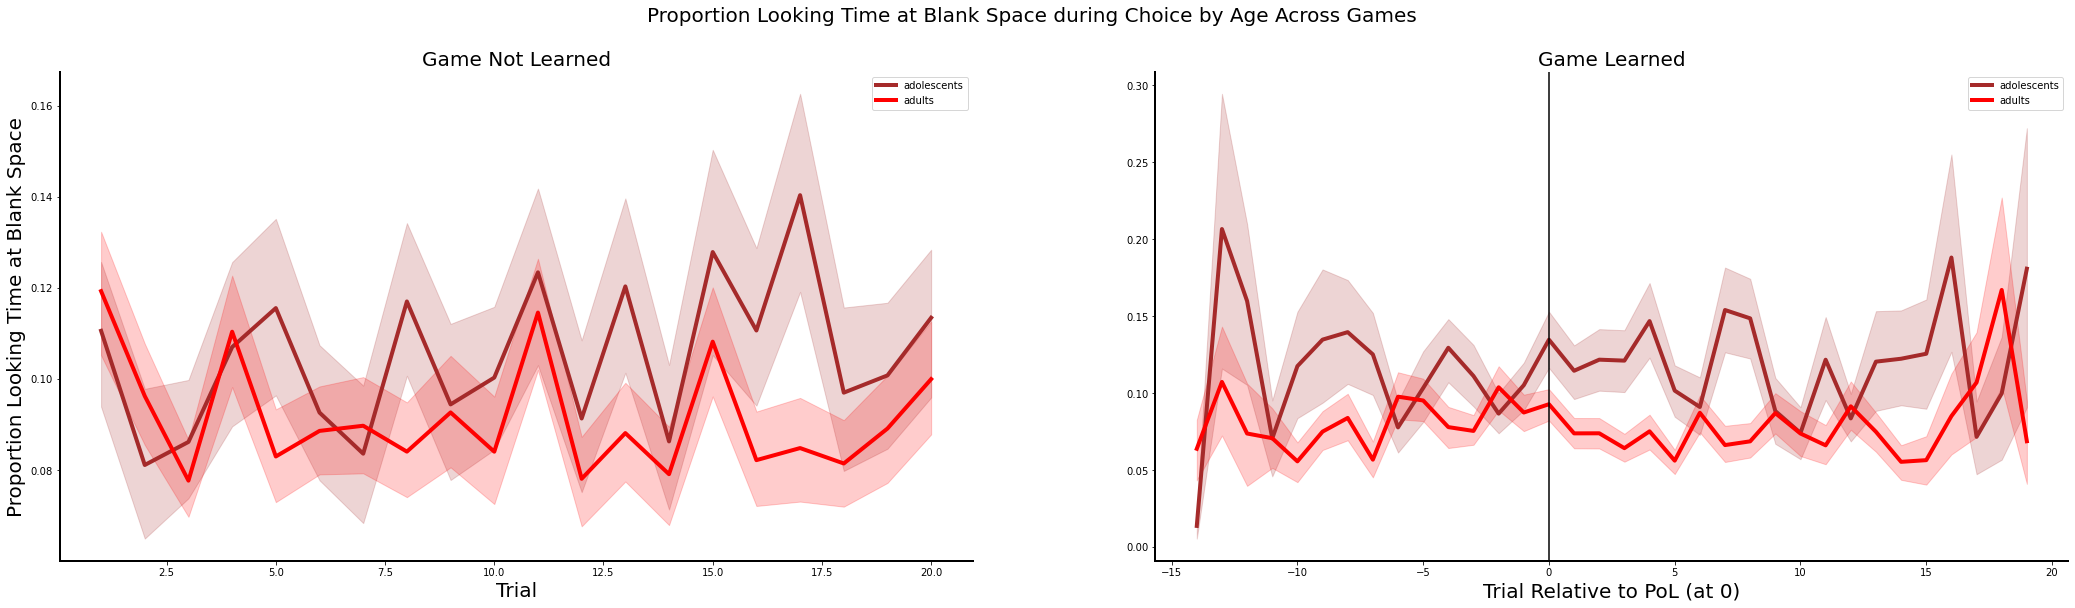

In [63]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['Feature10'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='AlignedTrial', value_vars=['Feature10'])

uncombined_df_adult = pd.melt(adult_unlearned_trials, col_level=0, id_vars='WithinGameTrial', value_vars=['Feature10'])
uncombined_df_adole = pd.melt(adole_unlearned_trials, col_level=0, id_vars='WithinGameTrial', value_vars=['Feature10'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(36,9))
fig.suptitle('Proportion Looking Time at Blank Space during Choice by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=68, data=uncombined_df_adole, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'AlignedTrial', y="value", err_style="band", ci=68, data=combined_df_adole, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=68, data=uncombined_df_adult, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'AlignedTrial', y="value", err_style="band", ci=68, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([0,1])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax2.set_ylim([0,1])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Proportion Looking Time at Blank Space',fontsize = 20);
x2 = ax2.set_xlabel('Trial Relative to PoL (at 0)',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')
ax2.axvline(x = 0, color = 'k', label = 'Point of Learning')

# Add "Learned" Subject-wide Parameter

In [46]:
behav_data = behav_data.rename(columns={"LearnedFeat": "LearnedGame"})
sub_learned = behav_data.groupby(['Subj'])['LearnedGame'].mean().reset_index().rename(columns={"LearnedGame": "MeanLearned"})
# behav_data = behav_data
sub_learned['Learned'] = sub_learned.MeanLearned > 0.5
behav_data = behav_data.merge(sub_learned, how="left", on='Subj')

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Correct,LearnedGame,RT,WithinGameTrial,PoL,Adult,Age,AgeGroup,MeanLearned,Learned
0,23,1,1,1,6,8,2,5,7,3,...,1.0,False,1.12700,1,18.0,False,15.105033,Adolescent,0.65,True
1,23,2,1,2,5,7,1,4,8,3,...,1.0,False,1.08580,2,18.0,False,15.105033,Adolescent,0.65,True
2,23,3,1,3,4,7,2,5,9,1,...,0.0,False,1.24420,3,18.0,False,15.105033,Adolescent,0.65,True
3,23,4,1,1,4,7,2,5,8,3,...,1.0,False,0.47509,4,18.0,False,15.105033,Adolescent,0.65,True
4,23,5,1,1,6,8,2,4,7,3,...,1.0,False,0.88090,5,18.0,False,15.105033,Adolescent,0.65,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,1.0,True,0.61252,16,6.0,True,22.508334,Adult,0.55,True
15196,71,397,20,1,5,8,2,4,9,3,...,1.0,True,0.89898,17,6.0,True,22.508334,Adult,0.55,True
15197,71,398,20,1,6,7,2,4,9,3,...,1.0,True,0.59331,18,6.0,True,22.508334,Adult,0.55,True
15198,71,399,20,1,6,7,3,5,8,2,...,1.0,True,0.52019,19,6.0,True,22.508334,Adult,0.55,True


In [48]:
behav_data.to_csv(os.getcwd() + '/ProcessedData/CleanedProcessedBehavioralData.csv', index=False)

# Dump

In [34]:
pd.DataFrame.from_dict(numCorrectOnSubsequentTrials).sort_values(['Subj','Game'], ascending = (True, True)).reset_index(drop=True)

,Subj,Game,WithinGameTrial,SubsequentCorrect,EightyPercent
0,23.0,1.0,1,15.0,False
1,23.0,1.0,2,14.0,False
2,23.0,1.0,3,13.0,False
3,23.0,1.0,4,13.0,False
4,23.0,1.0,5,12.0,False
...,...,...,...,...,...
15195,71.0,20.0,16,5.0,True
15196,71.0,20.0,17,4.0,True
15197,71.0,20.0,18,3.0,True
15198,71.0,20.0,19,2.0,True


In [19]:
subsequentcorrect_df = pd.DataFrame.from_dict(numCorrectOnSubsequentTrials).sort_values(['Subj','Game'], ascending = (True, True)).reset_index(drop=True) #.rename(columns={"Correct": "SubsequentCorrect"})

Subj                 23.0
Game                  1.0
WithinGameTrial      11.0
SubsequentCorrect     8.0
EightyPercent        11.0
Name: 10, dtype: float64
Subj                 23.0
Game                  1.0
WithinGameTrial      16.0
SubsequentCorrect     4.0
EightyPercent        16.0
Name: 15, dtype: float64
Subj                 23.0
Game                  1.0
WithinGameTrial      18.0
SubsequentCorrect     3.0
EightyPercent        18.0
Name: 17, dtype: float64
Subj                 23.0
Game                  1.0
WithinGameTrial      19.0
SubsequentCorrect     2.0
EightyPercent        19.0
Name: 18, dtype: float64
Subj                 23.0
Game                  1.0
WithinGameTrial      20.0
SubsequentCorrect     1.0
EightyPercent        20.0
Name: 19, dtype: float64
Subj                 23.0
Game                  2.0
WithinGameTrial       1.0
SubsequentCorrect    18.0
EightyPercent         1.0
Name: 20, dtype: float64
Subj                 23.0
Game                  2.0
WithinGameTrial   